In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import nltk
from nltk.corpus import stopwords
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import numpy as np
from sklearn.model_selection import StratifiedKFold
from transformers import *
import tokenizers

train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
train.dropna(inplace=True)

In [2]:
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


In [3]:
def jaccard(str1, str2):
	a = set(str1.lower().split())
	b = set(str2.lower().split())
	if (len(a)==0) & (len(b)==0): return 0.5
	c = a.intersection(b)
	return float(len(c)) / (len(a) + len(b) - len(c))

results_jaccard=[]
for ind,row in train.iterrows():
	sentence1 = row.text
	sentence2 = row.selected_text
	jaccard_score = jaccard(sentence1,sentence2)
	results_jaccard.append([sentence1,sentence2,jaccard_score])
jaccard = pd.DataFrame(results_jaccard,columns=["text","selected_text","jaccard_score"])
train = train.merge(jaccard,how='outer')
train.head()

,textID,text,selected_text,sentiment,jaccard_score
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286


C:\Users\hys\AppData\Local\Temp\ipykernel_3064\1774058827.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  p1=sns.kdeplot(train['num_words_selected_text'], shade=True, color="g").set_title('Kernel Distribution of Number Of words')
C:\Users\hys\AppData\Local\Temp\ipykernel_3064\1774058827.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  p1=sns.kdeplot(train['num_words_text'], shade=True, color="b")


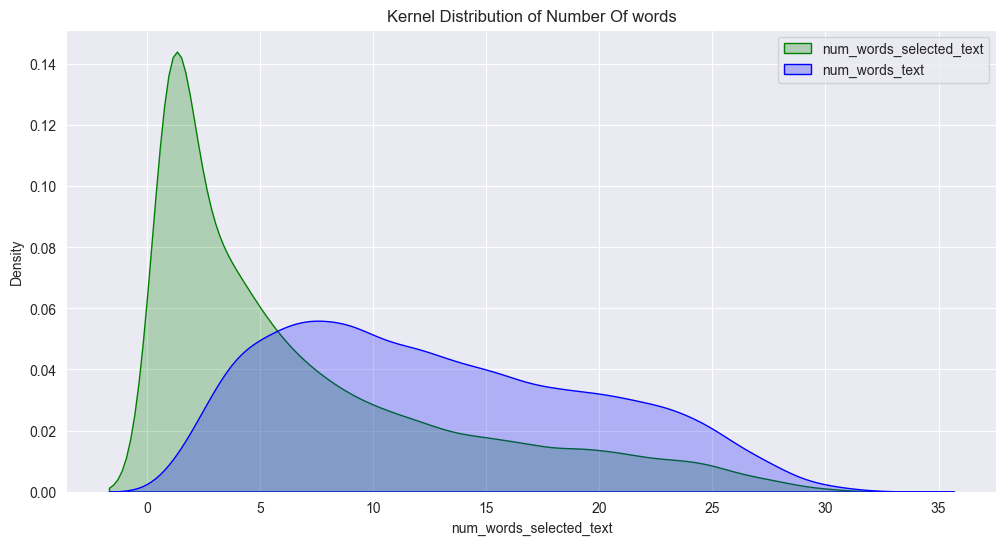

In [14]:
train['num_words_selected_text'] = train['selected_text'].apply(lambda x:len(str(x).split()))
train['num_words_text'] = train['text'].apply(lambda x:len(str(x).split()))
train['difference_in_words'] = train['num_words_text'] - train['num_words_selected_text']
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train['num_words_selected_text'], shade=True, color="g").set_title('Kernel Distribution of Number Of words')
p1=sns.kdeplot(train['num_words_text'], shade=True, color="b")
plt.legend(labels=['num_words_selected_text','num_words_text'])

C:\Users\hys\AppData\Local\Temp\ipykernel_3064\622051000.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  p1=sns.kdeplot(train[train['sentiment']=='positive']['difference_in_words'], shade=True, color="b").set_title('Kernel Distribution of Difference in Number Of words')
C:\Users\hys\AppData\Local\Temp\ipykernel_3064\622051000.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  p2=sns.kdeplot(train[train['sentiment']=='negative']['difference_in_words'], shade=True, color="g")


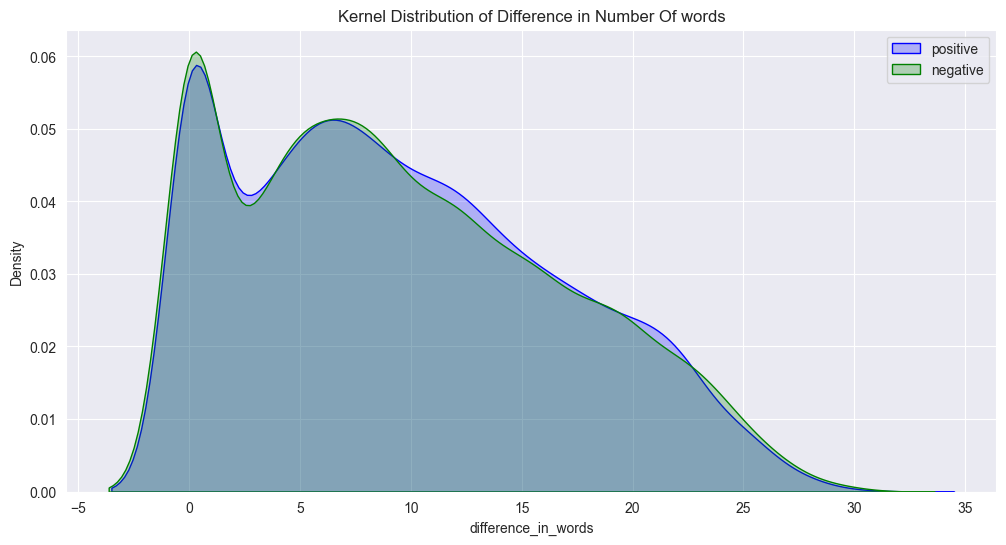

In [13]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['difference_in_words'], shade=True, color="b").set_title('Kernel Distribution of Difference in Number Of words')
p2=sns.kdeplot(train[train['sentiment']=='negative']['difference_in_words'], shade=True, color="g")
plt.legend(labels=['positive','negative'])

C:\Users\hys\AppData\Local\Temp\ipykernel_3064\2785895798.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  p1=sns.kdeplot(train[train['sentiment']=='positive']['jaccard_score'], shade=True, color="b").set_title('KDE of Jaccard Scores across different Sentiments')
C:\Users\hys\AppData\Local\Temp\ipykernel_3064\2785895798.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  p2=sns.kdeplot(train[train['sentiment']=='negative']['jaccard_score'], shade=True, color="g")


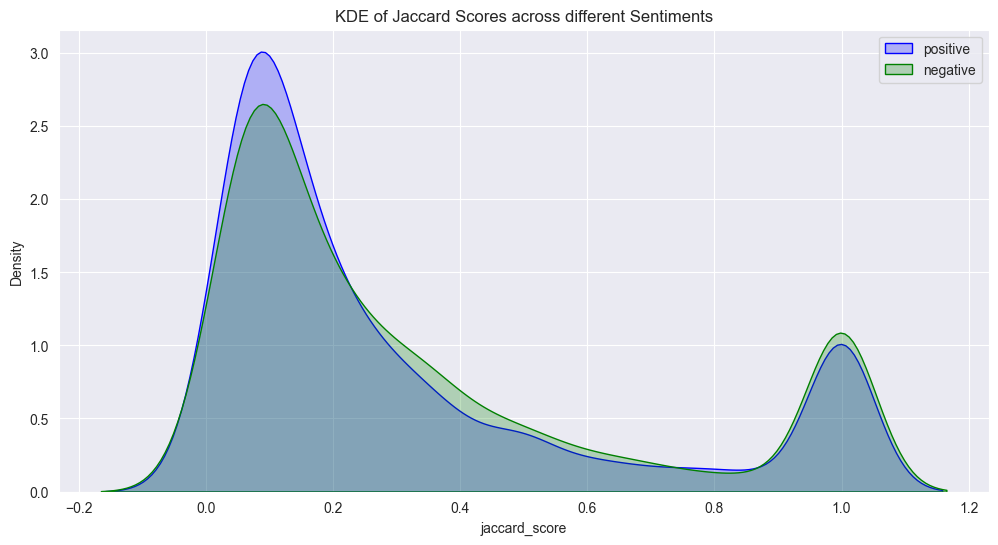

In [8]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['jaccard_score'], shade=True, color="b").set_title('KDE of Jaccard Scores across different Sentiments')
p2=sns.kdeplot(train[train['sentiment']=='negative']['jaccard_score'], shade=True, color="g")
plt.legend(labels=['positive','negative'])

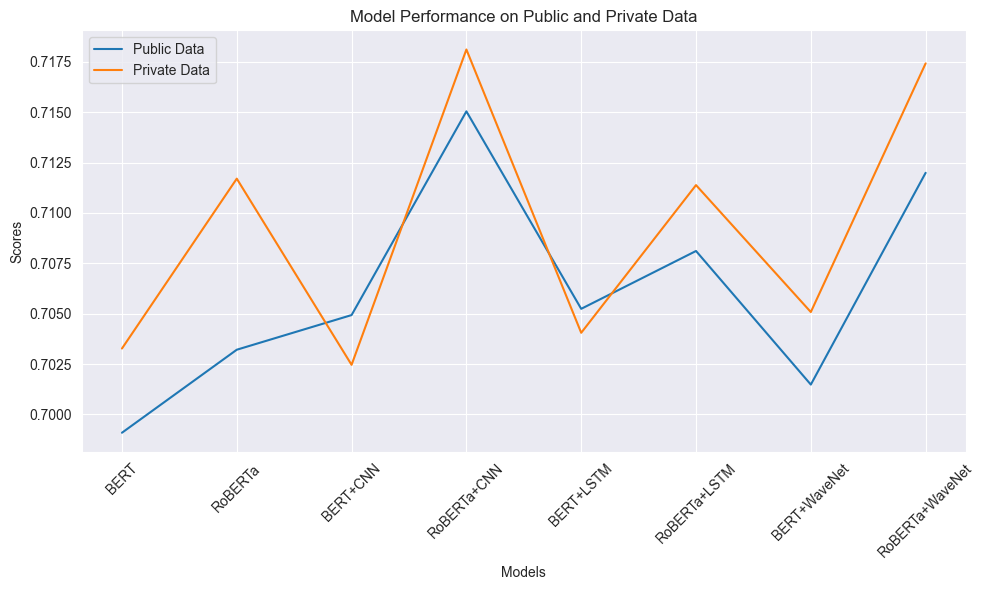

In [16]:
import matplotlib.pyplot as plt

models = ['BERT', 'RoBERTa', 'BERT+CNN', 'RoBERTa+CNN', 'BERT+LSTM', 'RoBERTa+LSTM', 'BERT+WaveNet', 'RoBERTa+WaveNet']
public_scores = [0.69909, 0.70321, 0.70493, 0.71504, 0.70524, 0.70811, 0.70148, 0.71199]
private_scores = [0.70327, 0.71170, 0.70246, 0.71811, 0.70405, 0.71138, 0.70508, 0.71742]

plt.figure(figsize=(10, 6))
plt.plot(models, public_scores, label='Public Data')
plt.plot(models, private_scores, label='Private Data')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance on Public and Private Data')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()

plt.show()